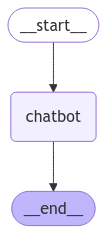

Assistant: Nice to meet
Assistant: I don't know
Assistant: I don't know.


In [ ]:
# Part 1 - Building a basic chatbot

from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_groq import ChatGroq
from IPython.display import Image, display
from decouple import Config, RepositoryEnv


secrets = Config(RepositoryEnv(".env"))

GROQ_API_KEY = secrets("GROQ_API_KEY")

groq_api_key = GROQ_API_KEY

# * The class "State" is a dict based on TypedDict; this means that we can specify
# which keys and what "type" of values it can have. We have defined it to have only 
# one key i.e. "messages" and the type of its value to be a list.
# * The `add_messages` function in the annotation defines how this state should be updated:
# we can only append messages to the list, not overwrite them.
# * However, in our current implementation, we are not saving the state anywhere; when we
# execute graph.stream(...), it initiates the graph with a new state.
class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

llm = ChatGroq(
    model="llama-3.3-70b-versatile",
    temperature=0.3,
    groq_api_key = groq_api_key
)

def chatbot(state: State):
    # print(state)
    return {"messages": [llm.invoke(state["messages"])]}


# * The first argument is the unique node name
# * The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)
graph = graph_builder.compile()

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass


# * In this case, we have only one node - hence, we would get only one output / event from graph.stream;
# but if we had multiple nodes, we would get multiple outputs / events i.e. one output for each node.
# * "event" is a dictionary containing the output of a node; its key is the name of that node e.g. "chatbot" and
# its values are the list of dictionaries returned by the chatbot function.
# * Our "chatbot" node is returning only a single dictionary, hence the list "event.values()" contains a
# single dictionary: {"messages": [llm.invoke(state["messages"])]}
# * In the dictionary {"messages": [llm.invoke(state["messages"])]}, the value stored against the "messages" key 
# is a list; in our case, we can see that this list contains a single item only i.e. the response of the llm.
def stream_graph_updates(user_input: str):
    system_prompt = {"role": "system", "content": "You respond in three words only."}
    user_prompt = {"role": "user", "content": user_input}
    for event in graph.stream({"messages": [system_prompt, user_prompt]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

i = 0
while True:
    try:
        # user_input = input("User: ")
        # if user_input.lower() in ["quit", "exit", "q"]:
        #     print("Goodbye!")
        #     break
        if i==0: user_input = "My name is Hassaan."
        if i==1: user_input = "What's my name?"
        if i==2: user_input = "What's the date today?" # llama3.3-70b hosted on groq fetches the actual date!
        stream_graph_updates(user_input)
        if i==2: break
        i += 1
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

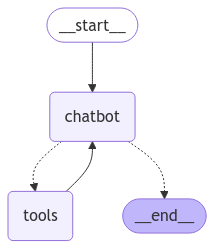

{'chatbot': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_qz2z', 'function': {'arguments': '{"query": "current date"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 288, 'total_tokens': 307, 'completion_time': 0.069090909, 'prompt_time': 0.024581758, 'queue_time': 0.058934361000000005, 'total_time': 0.093672667}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_8dd9fca28c', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-36fd10c1-20e5-46b7-b169-013d2784ec37-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current date'}, 'id': 'call_qz2z', 'type': 'tool_call'}], usage_metadata={'input_tokens': 288, 'output_tokens': 19, 'total_tokens': 307})]}}
Assistant: 
{'tools': {'messages': [ToolMessage(content='[{"title": "What Is Today\'s Date? - Inch Calculator", "url": "https://www.inchcalculator.com/what-is-today

In [110]:
# Part 2(a) - using custom BasicToolNode and route_tools (instead of the prebuilt ToolNode and tools_condition, respectively) - for learning purposes

from langchain_community.tools.tavily_search import TavilySearchResults
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_groq import ChatGroq
from langchain_core.messages import ToolMessage
import os
import json

from decouple import Config, RepositoryEnv


secrets = Config(RepositoryEnv(".env"))

TAVILY_API_KEY = secrets("TAVILY_API_KEY")
GROQ_API_KEY = secrets("GROQ_API_KEY")

os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY
tool = TavilySearchResults(max_results=2)
tools = [tool]

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

groq_api_key = GROQ_API_KEY
llm = ChatGroq(
    model="llama-3.3-70b-versatile",
    temperature=0.3,
    groq_api_key = groq_api_key
)
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        
        # This creates a dictionary containing each tool name as the key and the tool itself as the value against that key
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        # := is the walrus operator
        # It assigns the value inputs.get("messages", []) to "messages" variable inside the "if" condition.
        # If "messages" variable does not come out to be an empty list, the latest message (i.e. AIMessage) is assigned to
        # "message" variable. The "chatbot" we defined above outputs only a single msg i.e. the response of the LLM (llm_with_tools).
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        # The LLM's tool-calling support and binding the llm to the tools (llm.bind_tools - see above) results in tool_calls being added to the AIMEssage.
        # Each tool call contains the name of the tool that the LLM wants to call, the input ("args") to be fed to that tool as well as an ID for that tool call.
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            # For each tool call, we get the output of the relevant tool and append it to the "outputs" list.
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}

# We initialize the BasicToolNode class using the list of tools (see __init__ method of the class BasicToolNode)
tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

# Recall that edges route the control flow from one node to the next. Conditional edges usually contain "if" statements to 
# route to different nodes depending on the current graph state. These functions receive the current graph state and return 
# a string or list of strings indicating which node(s) to call next. In our case, we are returning just a string i.e. either
# "tools" or END.
# Below, define a router function called route_tools, that checks for tool_calls in the chatbot's output. Provide this 
# function to the graph by calling add_conditional_edges, which tells the graph that whenever the chatbot node completes, 
# check this function to see where to go next.
# The condition will route to tools if tool calls are present and END if not.
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge (add_conditional_edges) to route to the tool node(BasicToolNode) if the last message
    has tool calls. Otherwise, route to the end.
    """
    # This function gets, as an input, the output of the "chatbot" node - which has the same type as the class "State".
    # The first condition (if isinstance) would have held true if we had defined the chatbot node's output to be a list. 
    # However, we have defined its output to be a dictionary whose key is "messages" and whose value is a list 
    # containing a single message i.e. the LLM's response.
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `route_tools` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node.
    # It defaults to the identity function (i.e. value=key), but if we want to use a node named something else apart from "tools",
    # we can update the value of the dictionary to something else e.g. "tools": "my_tools".
    # NOTE: However, DON'T use the identify function if the key/value are going to be sth other than "tools"! That would
    # cause the code to silently fail / prevent the generation of graph's image (see code below: display(Image...)).
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

def stream_graph_updates(user_input: str):
    # Here, there are two nodes i.e. "chatbot" and "tools". So, we get the following events:
    # - chatbot's call to tools node
    # - tools node's output
    # - chatbot's response based on tools node's output
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        print(event)
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

i = 0
while True:
    if i==0: user_input = "What's the date today? Find it online."
    stream_graph_updates(user_input)
    if i==0: break
    i += 1

In [ ]:
# Part 2(b) - using the prebuilt ToolNode and tools_condition - NOTE: these do some nice things like parallel API execution

from langchain_community.tools.tavily_search import TavilySearchResults
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_groq import ChatGroq
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import Image, display

import os
import json

from decouple import Config, RepositoryEnv


secrets = Config(RepositoryEnv(".env"))

TAVILY_API_KEY = secrets("TAVILY_API_KEY")
GROQ_API_KEY = secrets("GROQ_API_KEY")

os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY
tool = TavilySearchResults(max_results=2)
tools = [tool]

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

groq_api_key = GROQ_API_KEY
llm = ChatGroq(
    model="llama-3.3-70b-versatile",
    temperature=0.3,
    groq_api_key = groq_api_key
)
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

# The `tools_condition` function directs the control flow towards either the "tools" node or END.
# Note that tools_condition is a prebuilt function; hence, we are required to use the name "tools" for our tools node;
# custom name is not allowed.
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
# graph_builder.add_edge(START, "chatbot")
graph_builder.set_entry_point("chatbot") # serves the same purpose as the above line
graph = graph_builder.compile()

# try:
#     display(Image(graph.get_graph().draw_mermaid_png()))
# except Exception as e:
#     print(f"error: {str(e)}")

def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        print(event)
        for value in event.values():
            print("Assistant:", value["messages"][-1].content, "\n")

i = 0
while True:
    if i==0: user_input = "What's the date today? Find it online."
    stream_graph_updates(user_input)
    if i==0: break
    i += 1

{'chatbot': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_6p94', 'function': {'arguments': '{"query": "current date"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 288, 'total_tokens': 307, 'completion_time': 0.069090909, 'prompt_time': 0.019130655, 'queue_time': 0.24759852, 'total_time': 0.088221564}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_90c1d253ff', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-584c6955-8a7f-4b94-9b1e-c794b2cf0599-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current date'}, 'id': 'call_6p94', 'type': 'tool_call'}], usage_metadata={'input_tokens': 288, 'output_tokens': 19, 'total_tokens': 307})]}}
Assistant:  

{'tools': {'messages': [ToolMessage(content='[{"title": "What Is Today\'s Date? - Inch Calculator", "url": "https://www.inchcalculator.com/what-is-todays-date/"

In [ ]:
# Part 3 - Adding Memory to the Chatbot

import os
import json
from langchain_community.tools.tavily_search import TavilySearchResults
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_groq import ChatGroq
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display
from decouple import Config, RepositoryEnv


secrets = Config(RepositoryEnv(".env"))

TAVILY_API_KEY = secrets("TAVILY_API_KEY")
GROQ_API_KEY = secrets("GROQ_API_KEY")

# Here, we're using an in-memory checkpointer. In a production application, change this to use SqliteSaver or PostgresSaver and connect to DB
memory = MemorySaver()

os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY
tool = TavilySearchResults(max_results=2)
tools = [tool]

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

groq_api_key = GROQ_API_KEY
llm = ChatGroq(
    model="llama-3.3-70b-versatile",
    temperature=0.3,
    groq_api_key = groq_api_key
)
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")

# Compile the graph with the provided checkpointer. This enables the graph to save the current state to memory.
graph = graph_builder.compile(checkpointer=memory)

# try:
#     display(Image(graph.get_graph().draw_mermaid_png()))
# except Exception as e:
#     print(f"error: {str(e)}")

# pick a thread to use as the key for this conversation
config_1 = {"configurable": {"thread_id": "1"}}
config_2 = {"configurable": {"thread_id": "2"}}

def stream_graph_updates(user_input: str, config):
    print("Next node:", snapshot.next)  # Check next node
    events = graph.stream(
        {"messages": [{"role": "user", "content": user_input}]},
        # The thread specified in config variable is used to identify whether to load an earlier state or initiate a fresh state.
        # If we use the same configs / thread_ids for subsequent queries, the graph would load the earlier state and hence
        # remember our conversation history.
        config,
        stream_mode="values",
        )
    for event in events:
        event["messages"][-1].pretty_print()

i = 0
while True:
    if i==0: 
        user_input = "My name is Hassaan."
        stream_graph_updates(user_input, config_1)
        snapshot = graph.get_state(config_1)
        print(snapshot)
    if i==1: 
        user_input = "What's the date today? Find it online"
        stream_graph_updates(user_input, config_1)
        snapshot = graph.get_state(config_1)
        print(snapshot)
    if i==1: break
    i += 1

Next node: ()
================================ Human Message =================================

My name is Hassaan.
================================== Ai Message ==================================

Hello Hassaan, it's nice to meet you. Is there something I can help you with or would you like to chat?
StateSnapshot(values={'messages': [HumanMessage(content='My name is Hassaan.', additional_kwargs={}, response_metadata={}, id='51fda78a-fa42-4eaa-8eb0-2f5d9301cd39'), AIMessage(content="Hello Hassaan, it's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 284, 'total_tokens': 311, 'completion_time': 0.098181818, 'prompt_time': 0.018730267, 'queue_time': 0.054310313, 'total_time': 0.116912085}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_41c250edc7', 'finish_reason': 'stop', 'logprobs': None}, id='run-a87eb050-b06a-4a6f-afcb-db54da3707

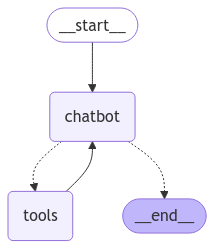

================================ Human Message =================================

I need some expert guidance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_QAFgm9xbqKvnNq9r2sNwZO3O)
 Call ID: call_QAFgm9xbqKvnNq9r2sNwZO3O
  Args:
    query: I need expert guidance for building an AI agent.
================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_QAFgm9xbqKvnNq9r2sNwZO3O)
 Call ID: call_QAFgm9xbqKvnNq9r2sNwZO3O
  Args:
    query: I need expert guidance for building an AI agent.
================================= Tool Message =================================
Name: human_assistance

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ========

In [113]:
# Part 4 - Human-in-the-loop

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display
from langgraph.types import Command, interrupt

import os
import json

from decouple import Config, RepositoryEnv


secrets = Config(RepositoryEnv(".env"))

TAVILY_API_KEY = secrets("TAVILY_API_KEY")
OPENAI_API_KEY = secrets("OPENAI_API_KEY")
GROQ_API_KEY = secrets("GROQ_API_KEY")

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

# NOTE: The chatbot/LLM determines which tool to call by analyzing its docstring. If I replace the
# docstring of human_assistance with "Don't call this function at all, it's very idiotic", the
# chatbot doesn't call any function at all!

# NOTE: The chatbot/LLM determines what value(s) to pass as arguments when calling the tools by looking
# at the names of the parameters. If we replaced "query" with "just_mention_your_favourite_food_here", 
# the chatbot may input "pizza" or sth like that when calling the human_assistance function!!

# The human_response variable fetches its value from whatever we provide when the interruption occurs.
@tool
def human_assistance(query: str) -> str: # just_mention_your_favourite_food_here # query
    """Request assistance from a human."""
    # """Don't call this function at all, it's very idiotic."""
    human_response = interrupt({"query": query})
    # print(f"human_response: {human_response}\nquery: {query}")
    return human_response["data"]

os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY
tool = TavilySearchResults(max_results=2)
tools = [tool, human_assistance]

# Groq llama3.3-70b wasn't performing well; after human_assistance gave its input to chatbot, the chatbot again called the human_assistance tool.
# Hence, replaced with gpt-4o.
openai_api_key = OPENAI_API_KEY
llm = ChatOpenAI(
    model="gpt-4o",
    temperature=0.3,
    api_key=openai_api_key
)

groq_api_key = GROQ_API_KEY

# model = "llama3-70b-8192"
# model = "llama3-70b-8192"
# model="llama-3.3-70b-versatile"
# model = "deepseek-r1-distill-llama-70b"

# llm = ChatGroq(
#     model=model,
#     temperature=0.3,
#     groq_api_key = groq_api_key
# )

llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    # NOTE: Basically, what this means is that we don't want tools other than human_assistance to be called because we don't want the flow to be interrupted until the human_assistance gives the go-ahead.
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"error: {str(e)}")

config_1 = {"configurable": {"thread_id": "1"}}

user_input = "I need some expert guidance for building an AI agent. Could you request assistance for me?"

# NOTE: Similar to Python's built-in input() function, calling interrupt inside the tool will pause execution. 
# Progress is persisted based on our choice of checkpointer-- so if we are persisting with Postgres, we can resume at any time as long as the database is alive. Here we are persisting with the in-memory checkpointer, so we can resume any time as long as our Python kernel is running. 
# To resume execution, we pass a Command object containing data expected by the tool. The format of this data can be customized based on our needs. Here, we just need a dict with a key "data".

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config_1,
    stream_mode="values",
    )
for event in events:
    event["messages"][-1].pretty_print()
snapshot = graph.get_state(config_1)
# print(snapshot)

# The chatbot generated a tool call, but then execution has been interrupted! 
# Note that if we inspect the graph state, we see that it stopped at the tools node.
# print("snapshot.next:", snapshot.next)

# NOTE: At this point, if, instead of passing the human_command, we repeat the above lines i.e. pass the user_input, we get:
# Error code: 400 - {'error': {'message': "An assistant message with 'tool_calls' must be followed by tool messages responding to each 'tool_call_id'. The following tool_call_ids did not have response messages: call_BOqwNiVqNZemELbM1fc1P0RQ", 'type': 'invalid_request_error', 'param': 'messages.[2].role', 'code': None}}
# During task with name 'chatbot' and id 'd5d118b1-27df-5cb9-b8ad-747946bd779b'

human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)

human_command = Command(resume={"data": human_response})

# When the following code is run, the last AI Message that was printed earlier as well i.e. tool call is again printed here.
events = graph.stream(human_command, config_1, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

In [ ]:
# Part 5 - Customizing State

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import InjectedToolCallId, tool
from langchain_core.messages import ToolMessage
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display
from langgraph.types import Command, interrupt

import os
import json

from decouple import Config, RepositoryEnv


secrets = Config(RepositoryEnv(".env"))

TAVILY_API_KEY = secrets("TAVILY_API_KEY")
OPENAI_API_KEY = secrets("OPENAI_API_KEY")

class State(TypedDict):
    messages: Annotated[list, add_messages]
    name: str
    birthday: str

graph_builder = StateGraph(State)

@tool
# Note that because we are generating a ToolMessage for a state update, we
# generally require the ID of the corresponding tool call. We can use
# LangChain's InjectedToolCallId to signal that this argument should not
# be revealed to the model in the tool's schema.

# NOTE: setting name and birthday in the arguments for the tool, we force the chatbot to generate proposals for these fields.
def human_assistance(
    name: str, birthday: str, tool_call_id: Annotated[str, InjectedToolCallId]
) -> str:
    """Request assistance from a human."""
    human_response = interrupt(
        {
            "question": "Is this correct?",
            "name": name,
            "birthday": birthday,
        },
    )
    # If the information is correct, update the state as-is.
    if human_response.get("correct", "").lower().startswith("y"):
        verified_name = name
        verified_birthday = birthday
        response = "Correct"
    # Otherwise, receive information from the human reviewer.
    else:
        verified_name = human_response.get("name", name)
        verified_birthday = human_response.get("birthday", birthday)
        response = f"Made a correction: {human_response}"

    # This time we explicitly update the state with a ToolMessage inside
    # the tool.
    state_update = {
        "name": verified_name,
        "birthday": verified_birthday,
        "messages": [ToolMessage(response, tool_call_id=tool_call_id)],
    }
    # We return a Command object in the tool to update our state.
    return Command(update=state_update)

os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY
tool = TavilySearchResults(max_results=2)
tools = [tool, human_assistance]

openai_api_key = OPENAI_API_KEY
llm = ChatOpenAI(
    model="gpt-4o",
    temperature=0.3,
    api_key=openai_api_key
)

llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

# try:
#     display(Image(graph.get_graph().draw_mermaid_png()))
# except Exception as e:
#     print(f"error: {str(e)}")

config = {"configurable": {"thread_id": "1"}}

user_input = (
    "Can you look up when LangGraph was released? "
    "When you have the answer, use the human_assistance tool for review."
)
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
    )
for event in events:
    event["messages"][-1].pretty_print()
snapshot = graph.get_state(config)
print("snapshot.next:", snapshot.next)

# We've hit the interrupt in the human_assistance tool again. 
# In this case, the chatbot failed to identify the correct date, so we can supply it:
human_command = Command(
    resume={
        "name": "LangGraph",
        "birthday": "Jan 17, 2024",
    },
)

# human_command = Command(
#     resume={
#         "correct": "yes"
#     },
# )

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

snapshot = graph.get_state(config)

# The fields "name" and "birthday" are easily accessible to downstream nodes (e.g., a node that further processes or stores the information).
{k: v for k, v in snapshot.values.items() if k in ("name", "birthday")}

================================ Human Message =================================

Can you look up when LangGraph was released? When you have the answer, use the human_assistance tool for review.
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_i9aJ4DCGKULOWjzjapP9aEsE)
 Call ID: call_i9aJ4DCGKULOWjzjapP9aEsE
  Args:
    query: LangGraph release date
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "langgraph - PyPI", "url": "https://pypi.org/project/langgraph/", "content": "langgraph · PyPI\nSkip to main content Switch to mobile version\n\nSearch PyPI  Search\n\nHelp\nSponsors\nLog in\nRegister\n\nMenu\n\nHelp\nSponsors\nLog in\nRegister\n\nSearch PyPI  Search\nlanggraph 0.2.70\npip install langgraph Copy PIP instructions\nLatest versionReleased: Feb 6, 2025\nBuilding stateful, multi-actor applications with LLMs\nNavigation\n\nProje

{'name': 'LangGraph', 'birthday': 'Jan 17, 2024'}

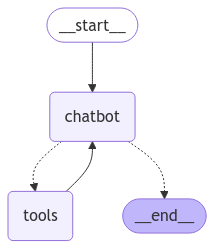

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_inGuhkU4k4HkwpBCk1BzY5rw)
 Call ID: call_inGuhkU4k4HkwpBCk1BzY5rw
  Args:
    query: LangGraph programming language
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "LangGraph: A Comprehensive Guide for Beginners - Bhavik Jikadara", "url": "https://bhavikjikadara.medium.com/langgraph-a-comprehensive-guide-for-beginners-ef17d3dd5383", "content": "Listen\nShare\nLangGraph is a library for building stateful, multi-actor applications with LLMs. It extends the LangChain Expression Language with the ability to coordinate multiple chains (or actors) across multiple steps of computation in a cyclic manner. It is inspired by Pregel and Apache Beam. 

In [111]:
# Part 6 - Time Travel

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import InjectedToolCallId, tool
from langchain_core.messages import ToolMessage
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display
from langgraph.types import Command, interrupt

import os
import json

from decouple import Config, RepositoryEnv


secrets = Config(RepositoryEnv(".env"))

TAVILY_API_KEY = secrets("TAVILY_API_KEY")
OPENAI_API_KEY = secrets("OPENAI_API_KEY")

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY
tool = TavilySearchResults(max_results=2)
tools = [tool]

openai_api_key = OPENAI_API_KEY
llm = ChatOpenAI(
    model="gpt-4o",
    temperature=0.3,
    api_key=openai_api_key
)

llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    return {"messages": [message]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"error: {str(e)}")

config = {"configurable": {"thread_id": "1"}}

user_input = (
            "I'm learning LangGraph. "
            "Could you do some research on it for me?"
)
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
    )
for event in events:
    event["messages"][-1].pretty_print()

user_input = (
            "Ya that's helpful. Can you please look up online and guide me how to build an autonomous agent with it?"
)
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
    )
for event in events:
    event["messages"][-1].pretty_print()

# Notice that checkpoints are saved for every step of the graph. This spans invocations so you can rewind across a full thread's history.
to_replay = None
for state in graph.get_state_history(config):
    print("Num Messages: ", len(state.values["messages"]), "Next: ", state.next)
    print("-" * 80)
    if len(state.values["messages"]) == 6:
        # We are somewhat arbitrarily selecting a specific state based on the number of chat messages in the state.
        to_replay = state

print(to_replay.next)
print(to_replay.config)

# The `checkpoint_id` in the `to_replay.config` corresponds to a state we've persisted to our checkpointer.
# Providing this checkpoint_id value tells LangGraph's checkpointer to load the state from that moment in time.
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    if "messages" in event:
        event["messages"][-1].pretty_print()
